### Human Activity Recognition
---
The aim of this project was labelling different human activities upon the data register by 5 dimensional signals a 2-axes accelerometer and a 3-axes gyroscope.

The set of activities recorded for labelling were:

- running
- walking
- standing
- sitting
- lying

The data provided for this assignment corresponded to 10 different people, 8 of them labelled and 2 of them unlabelled. Each of the recordings lasted less than 20 minutes.

In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
from google.colab import drive
from scipy.io import loadmat, savemat
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from keras.preprocessing import sequence
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix
%matplotlib inline

#### Load the dataset.

The labelled data was transferred into a pandas dataframe, which resulted into a matrix of 141,426 rows and 8 columns. Each row corresponded to a measurement performed every 0.0625s, as the recording frequency was 16 Hz. On the other hand, the first five columns corresponded to the sensors that recorded the movements and the remaining three accounted for the user number, the labelled activity and the timestamp.

In [44]:
# Mount the drive folder
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/DASS/Assignment 2')

# Open the file and read in data
data = loadmat('HAR_database.mat')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Retrieve basic information about the raw dataset
n_people = len(data['database_training'])
n_sensors = len(data['database_training'][0][0])
len_seq = [len(data['database_training'][i][0][0]) for i in range(n_people)]

print("Information about the dataset")
print("==========================")
print('n_people: %i \nn_sensors: %i '%(n_people, n_sensors))

print("\nSequence information")
print("==========================")
pd.Series(len_seq).describe()

Information about the dataset
n_people: 8 
n_sensors: 5 

Sequence information


count        8.000000
mean     17678.250000
std        447.895635
min      16920.000000
25%      17436.750000
50%      17673.000000
75%      17883.500000
max      18411.000000
dtype: float64

In [0]:
# Transform the data into a nice formatted dataset
for i in range(n_people):
  if i==0:
    df = pd.DataFrame(data['database_training'][i][0].transpose(), columns=['acc_z', 'acc_XY', 'gy_x',
                                                                            'gy_y', 'gy_z'])
    df['User']=len(data['database_training'][i][1][0])*[0]
    df['Activity']=data['database_training'][i][1][0]
    df['Timestamp']=range(len(data['database_training'][i][1][0]))
  else:
    df2 = pd.DataFrame(data['database_training'][i][0].transpose(), columns=['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z'])
    df2['User']=len(data['database_training'][i][1][0])*[i]
    df2['Activity']=data['database_training'][i][1][0]
    df2['Timestamp']=range(len(data['database_training'][i][1][0]))
    df = df.append(df2, ignore_index=True)

In [47]:
df

,acc_z,acc_XY,gy_x,gy_y,gy_z,User,Activity,Timestamp
0,0.024173,0.594417,-0.022736,0.111962,0.060499,0,3,0
1,0.019905,0.602472,-0.012875,0.103796,0.055157,0,3,1
2,0.034749,0.525821,-0.020016,0.103193,0.057541,0,3,2
3,0.059832,0.621057,-0.026841,0.104378,0.063853,0,3,3
4,0.044743,0.653001,-0.014540,0.103560,0.066084,0,3,4
...,...,...,...,...,...,...,...,...
141421,0.577717,1.784139,-0.081926,-0.095167,0.068769,7,3,17605
141422,0.577288,1.860482,-0.080316,-0.088788,0.071567,7,3,17606
141423,0.583964,1.844136,-0.073664,-0.101740,0.081287,7,3,17607
141424,0.572480,1.783769,-0.073399,-0.089936,0.052906,7,3,17608


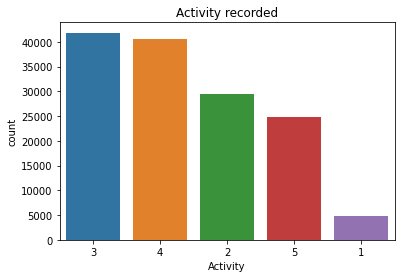

In [48]:
# Plot the distribution of the labelled activities
sns.countplot(x = 'Activity',
              data = df,
              order = df.Activity.value_counts().index);

plt.title("Activity recorded");


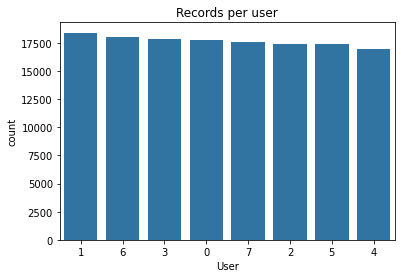

In [49]:
# Plot the number of records per user
sns.countplot(x = 'User',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.User.value_counts().index);
plt.title("Records per user");


In [0]:
# Function to plot the 5 sensor recordings given certain activity
def plot_activity(activity, df):
    data = df[df['Activity'] == activity][['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

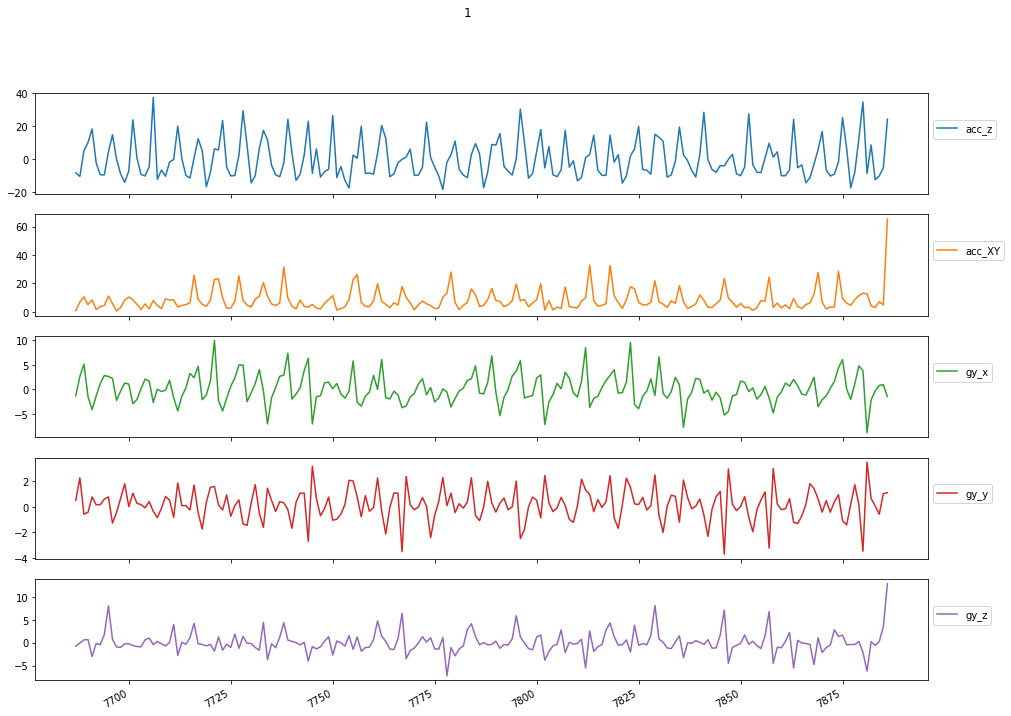

In [51]:
plot_activity(1, df);


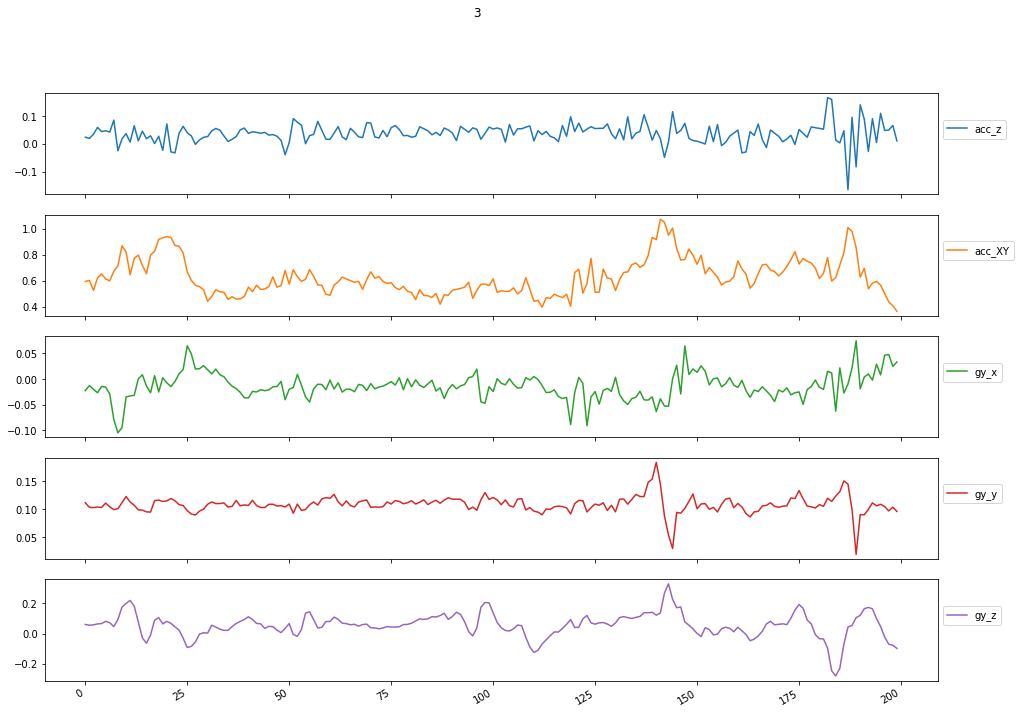

In [0]:
plot_activity(3, df);


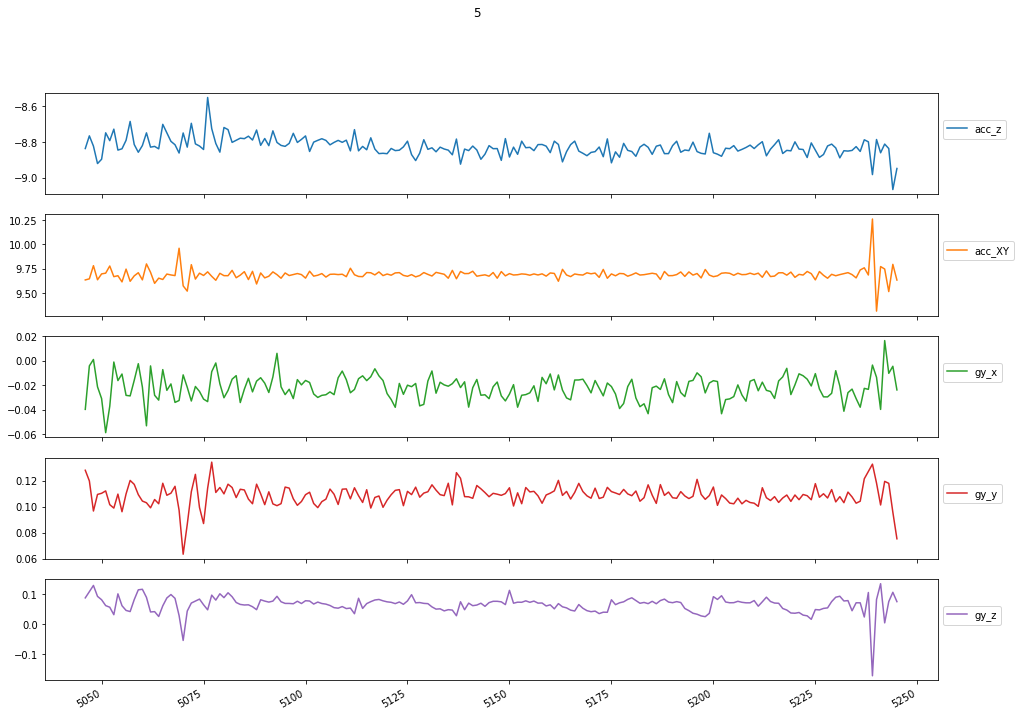

In [0]:
plot_activity(5, df);


### Pre-processing.

This section consists on four procedurals used to clear out the data and to set it ready for fitting it to the model. Those are:

- Splitting the data into train and test sets.
- Scaling the sensor data.
- Creating sequences.
- One-hot encoding the categorical variables.

In [0]:
# Split the dataset into train and test sets
df_train = df_train = df[df['User'] <= 6]
df_test = df[df['User'] > 6]

Data recorded by the sensors was scaled using a scaler robust to statistical outliers. The motivation to scale the data is to avoid features with larger values to impact the algorithm with a higher weight although its relevance is similar to features with smaller values.

In [53]:
#Scale the sensor data
scale_columns = ['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
# Function to create sequences
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

Sequences were created so the model was able to handle the data more easily. Thus, the raw data was summarized into sequences of 1 timestep, were each step was worth 10 measurements. The labelling for every step was created upon the mode of the previous mentioned measurements. The remaining sequences had the shape (12382, 1, 5), which can be understood as a total of 12,382 sequences, each 1 timestep long, containing the 5 sensor measurements with its corresponding label.

In [0]:
# Create sequences from the train and test datasets
TIME_STEPS = 1
STEP = 10

X_train, y_train = create_dataset(
    df_train[['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z']],
    df_train.Activity,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z']],
    df_test.Activity,
    TIME_STEPS,
    STEP
)

In [0]:
print(X_train.shape, y_train.shape)

(12382, 1, 5) (12382, 1)


In [0]:
# One-hot encode the labelled activities
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

### Create and fit the model.

Long Short Term Memory is an algorithm used on the deep learning field to classify time series data, as the one used on this assignment. The difficulty of this problem relies on the length of the sequences and variety of possible inputs the model can receive over time. Therefore, it is necessary for the model to learn the long-term dependencies between the coordinates given by the input sequence.

The main difference between regular neural networks and this model is that it has feedback connections, allowing it to remember what has been previously learnt. That is, maintaining state memory across long sequences. Instead of regular neurons, LSTM networks include a memory cells which let them learn long-term dependencies. These cells are formed by a set of gates that control when information is output, input and forgotten.

Moreover, this procedure simplified the feature extraction, dimensionality reduction and classification steps into a single command. Just by training the neural network, the model will have retrieved the features, learnt what makes the difference and classified the input upon this knowledge.

The model used for classifying the sequences was a bidirectional LSTM, accompanied by a dropout layer (which helps avoiding overfitting) and two activation layers (which introduce non linearity to the output). The model was fitted to 20 epochs, each trained to 11,143 samples and validated onto 1,239 other ones.


In [0]:
# Create the LSTM model with keras
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)


In [58]:
# Fit the data to the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 11143 samples, validate on 1239 samples
Epoch 1/20
11143/11143 [==============================] - 3s 232us/step - loss: 0.8127 - acc: 0.7249 - val_loss: 0.2921 - val_acc: 0.9161
Epoch 2/20
11143/11143 [==============================] - 2s 157us/step - loss: 0.3851 - acc: 0.8725 - val_loss: 0.2058 - val_acc: 0.9387
Epoch 3/20
11143/11143 [==============================] - 2s 164us/step - loss: 0.3290 - acc: 0.8921 - val_loss: 0.1859 - val_acc: 0.9419
Epoch 4/20
11143/11143 [==============================] - 2s 168us/step - loss: 0.3111 - acc: 0.8986 - val_loss: 0.1702 - val_acc: 0.9451
Epoch 5/20
11143/11143 [==============================] - 2s 177us/step - loss: 0.2942 - acc: 0.9042 - val_loss: 0.1666 - val_acc: 0.9451
Epoch 6/20
11143/11143 [==============================] - 2s 171us/step - loss: 0.2845 - acc: 0.9103 - val_loss: 0.1624 - val_acc: 0.9492
Epoch 7/20
11143/11143 [==============================] - 2s 169us/step - loss: 0.2696 - acc: 0.9144 - val_loss: 0.1547 - v

### Evaluate the model.
The aim of this section was to evaluate the model in terms of overfitting and accuracy.The model showed no relevant overfitting and an accuracy of 83.1%.

Moreover, there was created a confusion matrix in order to asses the labelling of each of the classes. It showed the most misclassified class was sitting (note the index of the classes should sum one to match the integer classes).

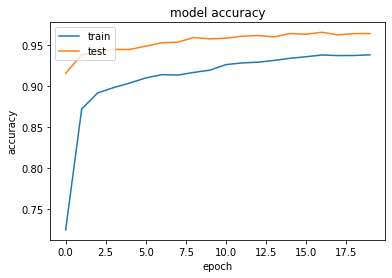

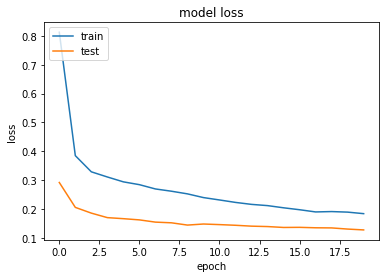

In [59]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
# Evaluate the accuracy on the test set
model.evaluate(x=X_test,y=y_test)

1761/1761 [==============================] - 0s 40us/step


[0.6171328042470414, 0.8319137096405029]

In [61]:
# Create confusion matrix
y_pred = model.predict(X_test)
y_test = y_test.argmax(1)
y_pred= y_pred.argmax(1)

import seaborn as sns
conf = confusion_matrix(y_test, y_pred)
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(conf)
x=x.style.background_gradient(cmap=cm)
display(x)

,0,1,2,3,4
0,23,25,2,0,1
1,8,282,14,7,0
2,0,1,502,0,0
3,0,1,0,575,0
4,0,0,0,237,83


### Predict the unlabelled sequences.

Finally, the unlabelled data was prepocessed as the prior data set and inputed to trained model in order to predict the missing labels.

In [0]:
# Reformat the unlabelled raw data
n_people = len(data['database_test'])
for i in range(n_people):
  if i==0:
    df_pred = pd.DataFrame(data['database_test'][i][0].transpose(), columns=['acc_z', 'acc_XY', 'gy_x',
                                                                            'gy_y', 'gy_z'])
    df_pred['User']=len(data['database_test'][i][0][0])*[0]
    df_pred['Timestamp']=range(len(data['database_test'][i][0][0]))
    df_pred['Activity']=len(data['database_test'][i][0][0])*[0]
  else:
    df2 = pd.DataFrame(data['database_test'][i][0].transpose(), columns=['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z'])
    df2['User']=len(data['database_test'][i][0][0])*[i]
    df2['Timestamp']=range(len(data['database_test'][i][0][0]))
    df2['Activity']=len(data['database_test'][i][0][0])*[0]

In [63]:
df_pred.shape

(19573, 8)

In [70]:
df2.shape

(22615, 8)

In [0]:
# Scale the sensor information data

df_pred.loc[:, scale_columns] = scaler.transform(
  df_pred[scale_columns].to_numpy()
)

df2.loc[:, scale_columns] = scaler.transform(
  df2[scale_columns].to_numpy()
)


In [0]:
# Create a sequence with the unlabelled dataframe

# Function to create sequences
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X)):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


TIME_STEPS = 1
STEP = 1

X_topred, y_topred = create_dataset(
    df_pred[['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z']],
    df_pred.Activity,
    TIME_STEPS,
    STEP
)


X_topred2, y_topred2 = create_dataset(
    df2[['acc_z', 'acc_XY', 'gy_x','gy_y', 'gy_z']],
    df2.Activity,
    TIME_STEPS,
    STEP
)

In [66]:
X_topred.shape

(19573, 1, 5)

In [67]:
X_topred2.shape

(22615, 1, 5)

In [0]:
# Predict the features labelling using the model
y_topred = model.predict(X_topred)
y_topred = y_topred.argmax(1)


y_topred2 = model.predict(X_topred2)
y_topred2 = y_topred2.argmax(1)

In [69]:
len(y_topred)

19573

In [71]:
len(y_topred2)

22615

In [0]:
y_topred = y_topred + 1
y_topred2 = y_topred2 + 1

In [0]:
savemat('predictions2.mat', {'user_1': y_topred, 'user_2': y_topred2})